# 07_1_LEARN-DataAnalysisML

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/07_1_LEARN_DataAnalysis.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
# cloning the data repo
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


## 1. Setting up the AutoML library

In [3]:
%%capture 
!pip install h2o

In [4]:
import h2o
from h2o.automl import H2OAutoML

In [5]:
# If this doesnt work - install java. 
# Start the H2O cluster (locally)
h2o.init(ip="localhost", min_mem_size_GB=8)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 16 mins
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,5 months and 6 days !!!
H2O_cluster_name:,H2O_from_python_lucaslevassor_2gyzs4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.266 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [6]:
#h2o.shutdown()

### 1.1 Import out dataframe to h20 object

Train a model based on the target and the df

In [7]:
# Run ML with new input 
new_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_1st_iteration_all_analytics.csv')
new_input_for_ml

,Line_name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.972701
1,yp49_C01,1,2,5,9,0.536658
2,yp49_D01,2,4,7,3,0.175896
3,yp49_E01,2,1,5,7,0.345201
4,yp49_F01,3,3,6,1,26.416324
...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0.000000
163,yp51_D12,8,2,7,6,0.614962
164,yp51_E12,8,1,6,10,0.466688
165,yp50_F05,6,1,8,2,15.155009


In [8]:
new_input_for_ml['default_rank'] = new_input_for_ml['Amt_norm'].rank()
new_input_for_ml['max_rank'] = new_input_for_ml['Amt_norm'].rank(method='max')
new_input_for_ml['NA_bottom'] = new_input_for_ml['Amt_norm'].rank(na_option='bottom')
new_input_for_ml['pct_rank'] = new_input_for_ml['Amt_norm'].rank(pct=True)
new_input_for_ml = new_input_for_ml.sort_values(by= 'max_rank', ascending = False)

In [9]:
new_input_for_ml

,Line_name,0,1,2,3,Amt_norm,default_rank,max_rank,NA_bottom,pct_rank
73,yp50_D03,5,2,6,3,277.307816,167.0,167.0,167.0,1.000000
75,yp50_G03,6,2,6,5,176.917201,166.0,166.0,166.0,0.994012
86,yp50_E05,5,1,6,8,163.352037,165.0,165.0,165.0,0.988024
106,yp50_A09,4,2,6,3,152.013305,164.0,164.0,164.0,0.982036
126,yp51_A02,7,2,6,1,141.151036,163.0,163.0,163.0,0.976048
...,...,...,...,...,...,...,...,...,...,...
60,yp50_E01,5,3,5,7,0.000000,30.0,59.0,30.0,0.179641
114,yp50_D11,5,4,8,6,0.000000,30.0,59.0,30.0,0.179641
24,yp49_E05,2,3,7,8,0.000000,30.0,59.0,30.0,0.179641
27,yp49_H05,3,3,7,10,0.000000,30.0,59.0,30.0,0.179641


In [10]:
# Choosing which coloums to train on 
new_input_for_ml = new_input_for_ml[['Line_name','0','1','2','3','Amt_norm']]
new_input_for_ml.columns = ['Line_name','0','1','2','3','Amt_norm']

In [11]:
df_test = h2o.H2OFrame(pd.concat([new_input_for_ml], axis='columns'))
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Rows:167
Cols:6




,Line_name,0,1,2,3,Amt_norm
type,string,int,int,int,int,real
mins,NaN,1.0,1.0,5.0,1.0,0.0
mean,NaN,4.580838323353294,2.6826347305389233,6.562874251497007,5.305389221556882,17.189179575556167
maxs,NaN,8.0,4.0,8.0,10.0,277.3078163064027
sigma,NaN,2.253055064641254,1.1621014428030094,1.1696200092422182,2.8363232921290003,40.680610367197914
zeros,0,0,0,0,0,59
missing,0,0,0,0,0,0
0,yp50_D03,5.0,2.0,6.0,3.0,277.3078163064027
1,yp50_G03,6.0,2.0,6.0,5.0,176.91720093355448
2,yp50_E05,5.0,1.0,6.0,8.0,163.3520367899325


In [12]:
# Since the data is categorical we need to make it from numerical to categorical 
df_test['0']= df_test['0'].asfactor()
df_test['1']= df_test['1'].asfactor()
df_test['2'] = df_test['2'].asfactor()
df_test['3'] = df_test['3'].asfactor()

In [13]:
df_test.describe()

Rows:167
Cols:6




,Line_name,0,1,2,3,Amt_norm
type,string,enum,enum,enum,enum,real
mins,NaN,,,,,0.0
mean,NaN,,,,,17.189179575556167
maxs,NaN,,,,,277.3078163064027
sigma,NaN,,,,,40.680610367197914
zeros,0,,,,,59
missing,0,0,0,0,0,0
0,yp50_D03,5,2,6,3,277.3078163064027
1,yp50_G03,6,2,6,5,176.91720093355448
2,yp50_E05,5,1,6,8,163.3520367899325


Set some arguments for the autoML. 


Important here is that we dont split the dataset but rather keep the cross-validation validate a model internally, i.e., estimate the model performance without having to sacrifice a validation split. See: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html


## 2. RUN automl

Here we are defining the autoML object and after we can train it

In [14]:
# Select the columns we want to train on
feature_cols = ['0', '1', '2', '3']

# Initialize H2O autoML class
AutoML = H2OAutoML(
    max_runtime_secs=0,  # 1 hour =int(3600 * 1) , if unlimited time is wanted then set this to zero = 0
    max_models=None,  # None =  no limit
    nfolds=10,         # number of folds for k-fold cross-validation (nfolds=0 disables cross-validation)
    seed=1,            # Reproducibility
    exclude_algos = ["StackedEnsemble"],
    sort_metric = "MAE",
    keep_cross_validation_predictions=True 
)

Train a model based on the target and the df. 


It has been Commented out and saved as showed below

In [15]:
%%time

AutoML.train(
     x=feature_cols,
     y='Amt_norm',
     training_frame=df_test,
 ) 

AutoML progress: |█
13:24:37.831: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 167.0.

██████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 51.1 s, sys: 5.05 s, total: 56.2 s
Wall time: 1h 1s
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_8_20221215_132434_model_22


Status of Neuron Layers: predicting Amt_norm, regression, gaussian distribution, Quadratic loss, 1,601 weights/biases, 22.4 KB, 1,671,670 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,30,Input,15.0,,,,,,,,,
1,,2,50,RectifierDropout,30.0,0.0,0.0,0.155423,0.351785,0.0,-0.318059,0.852019,0.442928,1.227627
2,,3,1,Linear,,0.0,0.0,0.000949,0.000735,0.0,-0.102599,0.738409,-0.394456,0.0




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 45.930853000850924
RMSE: 6.777230481609056
MAE: 3.335469464610631
RMSLE: 0.607560508866344
Mean Residual Deviance: 45.930853000850924

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 519.4250352979468
RMSE: 22.790898080109674
MAE: 9.48473623441736
RMSLE: NaN
Mean Residual Deviance: 519.4250352979468

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,9.479498,4.383686,14.365232,15.532976,14.356224,8.450772,4.229580,3.628579,6.667943,12.140803,9.221432,6.201436
1,mean_residual_deviance,518.067930,433.830900,1236.335400,1145.772800,834.349700,325.518800,98.113360,26.391392,186.628630,436.039180,671.274050,220.256060
2,mse,518.067930,433.830900,1236.335400,1145.772800,834.349700,325.518800,98.113360,26.391392,186.628630,436.039180,671.274050,220.256060
3,r2,0.665335,0.235466,0.722849,0.426765,0.523778,0.789084,0.928504,0.979567,0.845968,0.597882,0.222816,0.616137
4,residual_deviance,518.067930,433.830900,1236.335400,1145.772800,834.349700,325.518800,98.113360,26.391392,186.628630,436.039180,671.274050,220.256060
5,rmse,20.627329,10.142387,35.161560,33.849266,28.885113,18.042140,9.905219,5.137255,13.661209,20.881552,25.908957,14.841026
6,rmsle,0.850962,0.214088,0.715972,1.219461,NaN,0.865462,0.817273,0.665971,0.626418,1.191425,0.768210,0.788470



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2022-12-15 14:18:46,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2022-12-15 14:18:46,9 min 34.787 sec,238571 obs/sec,10.0,1,1670.0,66.424261,4412.182506,63.655839,-1.682174
2,,2022-12-15 14:18:48,9 min 37.049 sec,737067 obs/sec,10010.0,1001,1671670.0,6.777230,45.930853,3.335469,0.972079



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,1.4,1.000000,1.000000,0.071935
1,2.7,0.962853,0.962853,0.069263
2,1.3,0.880319,0.880319,0.063326
3,0.1,0.850323,0.850323,0.061168
4,3.10,0.700540,0.700540,0.050393
5,2.8,0.612269,0.612269,0.044044
6,0.8,0.607257,0.607257,0.043683
7,3.6,0.598460,0.598460,0.043050
8,0.2,0.534740,0.534740,0.038467
9,3.5,0.531631,0.531631,0.038243



See the whole table with table.as_data_frame()


In [16]:
print('DOOOOOOONE')

DOOOOOOONE


## 3. Processing model


In [17]:
# saving the models
leaderboard = AutoML.leaderboard
lb= leaderboard
model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:,0])

out_path = 'ConStrain_on_google_colab/Data/processed/ML_data_leaderboard2'
for m_id in model_ids:
     mdl = h2o.get_model(m_id)
     h2o.save_model(model=mdl, path=out_path, force=True)

In [18]:
len(model_ids)

506

Now we want to extract the best models that are not StackedEnsemble

In [19]:
df_from_h2o_object = lb.as_data_frame(use_pandas=True, header=True)
df_from_h2o_object

,model_id,mae,rmse,mse,rmsle,mean_residual_deviance
0,DeepLearning_grid_1_AutoML_8_20221215_132434_model_22,9.484736,22.790898,519.425035,NaN,519.425035
1,DeepLearning_grid_1_AutoML_8_20221215_132434_model_38,9.905577,23.079883,532.680991,NaN,532.680991
2,DeepLearning_grid_1_AutoML_8_20221215_132434_model_13,10.123991,21.871767,478.374186,NaN,478.374186
3,XGBoost_grid_1_AutoML_8_20221215_132434_model_165,10.249442,23.281310,542.019405,NaN,542.019405
4,DeepLearning_grid_1_AutoML_8_20221215_132434_model_37,10.398796,22.792866,519.514725,NaN,519.514725
...,...,...,...,...,...,...
501,XRT_1_AutoML_8_20221215_132434,20.438842,36.302526,1317.873382,1.921897,1317.873382
502,GBM_grid_1_AutoML_8_20221215_132434_model_38,20.493587,33.548142,1125.477802,NaN,1125.477802
503,GBM_grid_1_AutoML_8_20221215_132434_model_155,20.578879,34.037974,1158.583694,NaN,1158.583694
504,DeepLearning_1_AutoML_8_20221215_132434,23.707335,34.644571,1200.246333,NaN,1200.246333


### 3.1 Saving the best model

In [20]:
best_model = AutoML.get_best_model()
best_model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_8_20221215_132434_model_22


Status of Neuron Layers: predicting Amt_norm, regression, gaussian distribution, Quadratic loss, 1,601 weights/biases, 22.4 KB, 1,671,670 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,30,Input,15.0,,,,,,,,,
1,,2,50,RectifierDropout,30.0,0.0,0.0,0.155423,0.351785,0.0,-0.318059,0.852019,0.442928,1.227627
2,,3,1,Linear,,0.0,0.0,0.000949,0.000735,0.0,-0.102599,0.738409,-0.394456,0.0




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 45.930853000850924
RMSE: 6.777230481609056
MAE: 3.335469464610631
RMSLE: 0.607560508866344
Mean Residual Deviance: 45.930853000850924

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 519.4250352979468
RMSE: 22.790898080109674
MAE: 9.48473623441736
RMSLE: NaN
Mean Residual Deviance: 519.4250352979468

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,9.479498,4.383686,14.365232,15.532976,14.356224,8.450772,4.229580,3.628579,6.667943,12.140803,9.221432,6.201436
1,mean_residual_deviance,518.067930,433.830900,1236.335400,1145.772800,834.349700,325.518800,98.113360,26.391392,186.628630,436.039180,671.274050,220.256060
2,mse,518.067930,433.830900,1236.335400,1145.772800,834.349700,325.518800,98.113360,26.391392,186.628630,436.039180,671.274050,220.256060
3,r2,0.665335,0.235466,0.722849,0.426765,0.523778,0.789084,0.928504,0.979567,0.845968,0.597882,0.222816,0.616137
4,residual_deviance,518.067930,433.830900,1236.335400,1145.772800,834.349700,325.518800,98.113360,26.391392,186.628630,436.039180,671.274050,220.256060
5,rmse,20.627329,10.142387,35.161560,33.849266,28.885113,18.042140,9.905219,5.137255,13.661209,20.881552,25.908957,14.841026
6,rmsle,0.850962,0.214088,0.715972,1.219461,NaN,0.865462,0.817273,0.665971,0.626418,1.191425,0.768210,0.788470



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2022-12-15 14:18:46,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2022-12-15 14:18:46,9 min 34.787 sec,238571 obs/sec,10.0,1,1670.0,66.424261,4412.182506,63.655839,-1.682174
2,,2022-12-15 14:18:48,9 min 37.049 sec,737067 obs/sec,10010.0,1001,1671670.0,6.777230,45.930853,3.335469,0.972079



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,1.4,1.000000,1.000000,0.071935
1,2.7,0.962853,0.962853,0.069263
2,1.3,0.880319,0.880319,0.063326
3,0.1,0.850323,0.850323,0.061168
4,3.10,0.700540,0.700540,0.050393
5,2.8,0.612269,0.612269,0.044044
6,0.8,0.607257,0.607257,0.043683
7,3.6,0.598460,0.598460,0.043050
8,0.2,0.534740,0.534740,0.038467
9,3.5,0.531631,0.531631,0.038243



See the whole table with table.as_data_frame()


In [21]:
model_path = h2o.save_model(model=best_model, path="ConStrain_on_google_colab/Data/processed/ML_models", force=True)

### 3.2 Exporting the leaderboard

In [22]:
# saving the leaderboard
import os
h2o.export_file(leaderboard, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


### 3.3 Importing the leaderboard

In [23]:
models_path = "ConStrain_on_google_colab/Data/processed/ML_data_leaderboard2/"

lb = h2o.import_file(path=os.path.join(models_path, "aml_leaderboard.h2o"))
lb

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,mae,rmse,mse,rmsle,mean_residual_deviance
DeepLearning_grid_1_AutoML_8_20221215_132434_model_22,9.48474,22.7909,519.425,nan,519.425
DeepLearning_grid_1_AutoML_8_20221215_132434_model_38,9.90558,23.0799,532.681,nan,532.681
DeepLearning_grid_1_AutoML_8_20221215_132434_model_13,10.124,21.8718,478.374,nan,478.374
XGBoost_grid_1_AutoML_8_20221215_132434_model_165,10.2494,23.2813,542.019,nan,542.019
DeepLearning_grid_1_AutoML_8_20221215_132434_model_37,10.3988,22.7929,519.515,nan,519.515
DeepLearning_grid_1_AutoML_8_20221215_132434_model_17,10.4231,22.4236,502.816,nan,502.816
XGBoost_grid_1_AutoML_8_20221215_132434_model_292,10.5124,23.5539,554.785,nan,554.785
DeepLearning_grid_1_AutoML_8_20221215_132434_model_19,10.5338,23.5018,552.336,nan,552.336
DeepLearning_grid_1_AutoML_8_20221215_132434_model_35,10.5776,24.5099,600.737,nan,600.737
XGBoost_grid_1_AutoML_8_20221215_132434_model_131,10.9126,24.0953,580.583,nan,580.583


In [25]:
delim_whitespace=Truedelim_whitespace=Truedelim_whitespace=Truecsbbxcvbxxcvbdasfgsfgdsfg df#
   delim_whitespace=Truedelim_whitespace=Truesdvva
   sdfasdfasdasadddffdf
   
   
   
   
   
   
   fdad fasdffdddddddsadelim_whitespace=Truedggff saving best MAE model 
best_MAE_model = AutoML.get_best_model(algorithm="DeepLearning", criterion="mae")
best_MAE_model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_8_20221215_132434_model_22


Status of Neuron Layers: predicting Amt_norm, regression, gaussian distribution, Quadratic loss, 1,601 weights/biases, 22.4 KB, 1,671,670 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,30,Input,15.0,,,,,,,,,
1,,2,50,RectifierDropout,30.0,0.0,0.0,0.155423,0.351785,0.0,-0.318059,0.852019,0.442928,1.227627
2,,3,1,Linear,,0.0,0.0,0.000949,0.000735,0.0,-0.102599,0.738409,-0.394456,0.0




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 45.930853000850924
RMSE: 6.777230481609056
MAE: 3.335469464610631
RMSLE: 0.607560508866344
Mean Residual Deviance: 45.930853000850924

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 519.4250352979468
RMSE: 22.790898080109674
MAE: 9.48473623441736
RMSLE: NaN
Mean Residual Deviance: 519.4250352979468

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,9.479498,4.383686,14.365232,15.532976,14.356224,8.450772,4.229580,3.628579,6.667943,12.140803,9.221432,6.201436
1,mean_residual_deviance,518.067930,433.830900,1236.335400,1145.772800,834.349700,325.518800,98.113360,26.391392,186.628630,436.039180,671.274050,220.256060
2,mse,518.067930,433.830900,1236.335400,1145.772800,834.349700,325.518800,98.113360,26.391392,186.628630,436.039180,671.274050,220.256060
3,r2,0.665335,0.235466,0.722849,0.426765,0.523778,0.789084,0.928504,0.979567,0.845968,0.597882,0.222816,0.616137
4,residual_deviance,518.067930,433.830900,1236.335400,1145.772800,834.349700,325.518800,98.113360,26.391392,186.628630,436.039180,671.274050,220.256060
5,rmse,20.627329,10.142387,35.161560,33.849266,28.885113,18.042140,9.905219,5.137255,13.661209,20.881552,25.908957,14.841026
6,rmsle,0.850962,0.214088,0.715972,1.219461,NaN,0.865462,0.817273,0.665971,0.626418,1.191425,0.768210,0.788470



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2022-12-15 14:18:46,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2022-12-15 14:18:46,9 min 34.787 sec,238571 obs/sec,10.0,1,1670.0,66.424261,4412.182506,63.655839,-1.682174
2,,2022-12-15 14:18:48,9 min 37.049 sec,737067 obs/sec,10010.0,1001,1671670.0,6.777230,45.930853,3.335469,0.972079



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,1.4,1.000000,1.000000,0.071935
1,2.7,0.962853,0.962853,0.069263
2,1.3,0.880319,0.880319,0.063326
3,0.1,0.850323,0.850323,0.061168
4,3.10,0.700540,0.700540,0.050393
5,2.8,0.612269,0.612269,0.044044
6,0.8,0.607257,0.607257,0.043683
7,3.6,0.598460,0.598460,0.043050
8,0.2,0.534740,0.534740,0.038467
9,3.5,0.531631,0.531631,0.038243



See the whole table with table.as_data_frame()


## 4. Importing the best model

In [26]:
best_model = h2o.load_model("ConStrain_on_google_colab/Data/processed/ML_models/"+lb[0,0]) 
my_local_model = h2o.download_model(best_model, path="ConStrain_on_google_colab/Data/processed/ML_models/")
uploaded_model = h2o.upload_model(my_local_model)

In [27]:
best_model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_8_20221215_132434_model_22


Status of Neuron Layers: predicting Amt_norm, regression, gaussian distribution, Quadratic loss, 1,601 weights/biases, 22.4 KB, 1,671,670 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,30,Input,15.0,,,,,,,,,
1,,2,50,RectifierDropout,30.0,0.0,0.0,0.155423,0.351785,0.0,-0.318059,0.852019,0.442928,1.227627
2,,3,1,Linear,,0.0,0.0,0.000949,0.000735,0.0,-0.102599,0.738409,-0.394456,0.0




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 45.930853000850924
RMSE: 6.777230481609056
MAE: 3.335469464610631
RMSLE: 0.607560508866344
Mean Residual Deviance: 45.930853000850924

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 519.4250352979468
RMSE: 22.790898080109674
MAE: 9.48473623441736
RMSLE: NaN
Mean Residual Deviance: 519.4250352979468

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,9.479498,4.383686,14.365232,15.532976,14.356224,8.450772,4.229580,3.628579,6.667943,12.140803,9.221432,6.201436
1,mean_residual_deviance,518.067930,433.830900,1236.335400,1145.772800,834.349700,325.518800,98.113360,26.391392,186.628630,436.039180,671.274050,220.256060
2,mse,518.067930,433.830900,1236.335400,1145.772800,834.349700,325.518800,98.113360,26.391392,186.628630,436.039180,671.274050,220.256060
3,r2,0.665335,0.235466,0.722849,0.426765,0.523778,0.789084,0.928504,0.979567,0.845968,0.597882,0.222816,0.616137
4,residual_deviance,518.067930,433.830900,1236.335400,1145.772800,834.349700,325.518800,98.113360,26.391392,186.628630,436.039180,671.274050,220.256060
5,rmse,20.627329,10.142387,35.161560,33.849266,28.885113,18.042140,9.905219,5.137255,13.661209,20.881552,25.908957,14.841026
6,rmsle,0.850962,0.214088,0.715972,1.219461,NaN,0.865462,0.817273,0.665971,0.626418,1.191425,0.768210,0.788470



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2022-12-15 14:18:46,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2022-12-15 14:18:46,9 min 34.787 sec,238571 obs/sec,10.0,1,1670.0,66.424261,4412.182506,63.655839,-1.682174
2,,2022-12-15 14:18:48,9 min 37.049 sec,737067 obs/sec,10010.0,1001,1671670.0,6.777230,45.930853,3.335469,0.972079



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,1.4,1.000000,1.000000,0.071935
1,2.7,0.962853,0.962853,0.069263
2,1.3,0.880319,0.880319,0.063326
3,0.1,0.850323,0.850323,0.061168
4,3.10,0.700540,0.700540,0.050393
5,2.8,0.612269,0.612269,0.044044
6,0.8,0.607257,0.607257,0.043683
7,3.6,0.598460,0.598460,0.043050
8,0.2,0.534740,0.534740,0.038467
9,3.5,0.531631,0.531631,0.038243



See the whole table with table.as_data_frame()


### 4.1 Investigate the best model - Cross-validation holdout predictions

Get the cross validation predictions

In [75]:
cross_validation_holdout_predictions = best_model.predict(df_test)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [124]:
# This is where list of cv preds are stored (one element per fold):
cross_validation_holdout_predictions = best_model.cross_validation_holdout_predictions()

In [77]:
cross_validation_holdout_predictions.frame_id

'cv_holdout_prediction_DeepLearning_grid_1_AutoML_8_20221215_132434_model_22'

In [78]:
cv_fram = cross_validation_holdout_predictions.as_data_frame()
cv_fram

,predict
0,141.858058
1,56.197185
2,85.943359
3,130.045154
4,136.690333
...,...
162,0.606824
163,0.234127
164,2.162226
165,0.798118


In [79]:
# However you most likely want a single-column frame including all cv preds
cross_validation_predictions = best_model.cross_validation_predictions()
print(len(cross_validation_predictions))

10


In [80]:
as_data_frame_df_test = df_test.as_data_frame()
as_data_frame_CV_predictions = cross_validation_holdout_predictions.as_data_frame()

In [90]:
df3 = pd.merge(as_data_frame_df_test, as_data_frame_CV_predictions, left_index=True, right_index=True).sort_values(by= 'Amt_norm', ascending = False).reset_index()
df3.head(10)

,index,Line_name,0,1,2,3,Amt_norm,predict
0,0,yp50_D03,5,2,6,3,277.307816,141.858058
1,1,yp50_G03,6,2,6,5,176.917201,56.197185
2,2,yp50_E05,5,1,6,8,163.352037,85.943359
3,3,yp50_A09,4,2,6,3,152.013305,130.045154
4,4,yp51_A02,7,2,6,1,141.151036,136.690333
5,5,yp50_D07,5,2,5,5,140.230004,129.314144
6,6,yp49_F04,3,2,6,2,138.940568,91.170934
7,7,yp51_A01,7,2,5,1,127.125752,72.160940
8,8,yp50_F10,6,2,5,4,113.702822,12.529595
9,9,yp50_D05,5,2,8,4,93.912536,38.308369


#### Barplot of production vs prediction 

In [93]:
from constrain.plotting.plotting import bar_plot_w_hue

In [99]:
%%capture
# initialize
ds1 = df3[['Line_name', 'Amt_norm']]
ds1.columns = ['Line_name', 'strict']
ds2 = df3[['Line_name', 'predict']]
ds2.columns = ['Line_name', 'strict']

# add category
ds2['category'] = 'Predicted'
ds1['category'] = 'Strictosidine'
dss = pd.concat([ds1, ds2])

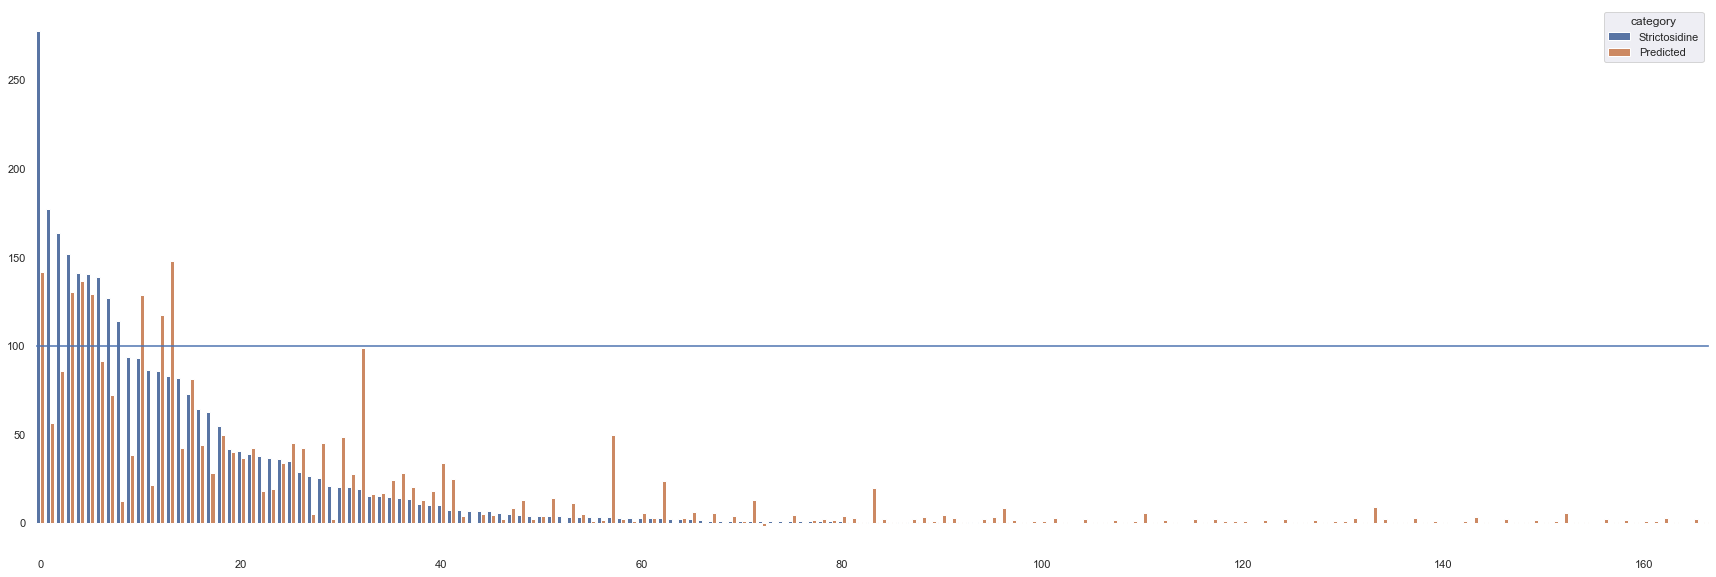

In [100]:
bar_plot_w_hue(dss, 'Line_name', 'strict', path = 'ConStrain_on_google_colab/Data/Plots_for_publication/07_1_LEARN_DataAnalysis/Prediction of the sampled library_ranked')

#### Ranking production and correlation plots 

In [97]:
df3['norm_strict_measured_rank_pct']= df3['Amt_norm'].rank(pct=True)
df3['Predicted_strict_production_rank_pct'] = df3['predict'].rank(pct=True)
df3.to_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_1st_iteration_w_predictions_and_ranking.csv')
df3

,index,Line_name,0,1,2,3,Amt_norm,predict,default_rank,default_rank_predicted,norm_strict_measured_rank_pct,Predicted_strict_production_rank_pct
0,0,yp50_D03,5,2,6,3,277.307816,141.858058,167.0,166.0,1.000000,0.994012
1,1,yp50_G03,6,2,6,5,176.917201,56.197185,166.0,155.0,0.994012,0.928144
2,2,yp50_E05,5,1,6,8,163.352037,85.943359,165.0,158.0,0.988024,0.946108
3,3,yp50_A09,4,2,6,3,152.013305,130.045154,164.0,164.0,0.982036,0.982036
4,4,yp51_A02,7,2,6,1,141.151036,136.690333,163.0,165.0,0.976048,0.988024
...,...,...,...,...,...,...,...,...,...,...,...,...
162,131,yp50_F12,6,4,7,4,0.000000,2.564601,30.0,94.5,0.179641,0.565868
163,132,yp51_E02,8,1,8,7,0.000000,0.606824,30.0,28.0,0.179641,0.167665
164,133,yp50_G06,6,4,6,6,0.000000,0.234127,30.0,9.0,0.179641,0.053892
165,134,yp50_E03,5,4,7,7,0.000000,2.162226,30.0,83.0,0.179641,0.497006


In [41]:
from constrain.plotting.plotting import correlation_plot

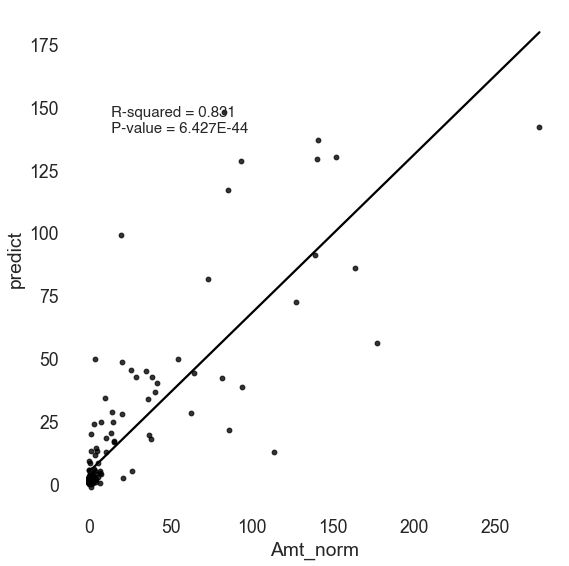

In [42]:
correlation_plot(df3,"Amt_norm","predict", save_pdf = True , path ='ConStrain_on_google_colab/Data/Plots_for_publication/07_1_LEARN_DataAnalysis/corr_plot_Amt_predict')

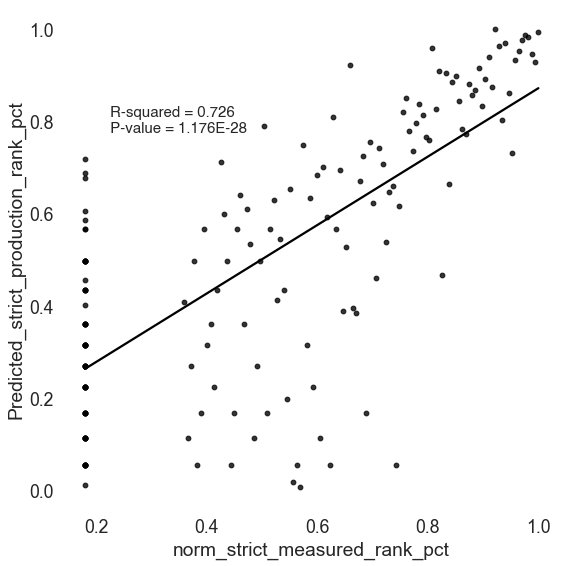

In [43]:
correlation_plot(df3,"norm_strict_measured_rank_pct","Predicted_strict_production_rank_pct", save_pdf = True , 
                 path ='ConStrain_on_google_colab/Data/Plots_for_publication/07_1_LEARN_DataAnalysis/corr_plot_rank_rank_predict')

## 5. Clean up data on the remaining library of combinations of genotypes

In [101]:
import numpy as np

In [102]:
all_genotypes = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/systematic_names_on_all_combinations.csv')
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))
all_genotypes_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


0,1,2,3
1,1,5,1
1,1,5,2
1,1,5,3
1,1,5,4
1,1,5,5
1,1,5,6
1,1,5,7
1,1,5,8
1,1,5,9
1,1,5,10


In [103]:
input_fixed = new_input_for_ml[['0','1','2','3']]
input_fixed

,0,1,2,3
73,5,2,6,3
75,6,2,6,5
86,5,1,6,8
106,4,2,6,3
126,7,2,6,1
...,...,...,...,...
60,5,3,5,7
114,5,4,8,6
24,2,3,7,8
27,3,3,7,10


Getting rid of the genotypes we have already tested:

In [104]:
df_diff = all_genotypes[~all_genotypes.apply(tuple,1).isin(input_fixed.apply(tuple,1))]
df_diff

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
3,1,1,5,4
4,1,1,5,5
6,1,1,5,7
...,...,...,...,...
1275,8,4,8,6
1276,8,4,8,7
1277,8,4,8,8
1278,8,4,8,9


In [105]:
# make the diff into a df 
all_genotypes_df = h2o.H2OFrame(pd.concat([df_diff], axis='columns'))
all_genotypes_df['0']= all_genotypes_df['0'].asfactor()
all_genotypes_df['1']= all_genotypes_df['1'].asfactor()
all_genotypes_df['2'] = all_genotypes_df['2'].asfactor()
all_genotypes_df['3'] = all_genotypes_df['3'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [106]:
predicted = best_model.predict(all_genotypes_df)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [107]:
len(predicted)

1121

In [108]:
predicted_norm = predicted.as_data_frame()
predicted_norm.head()

,predict
0,1.142488
1,1.142488
2,1.142488
3,1.142488
4,1.142488


## 6. Predict the  phenotypes from the whole library

In [109]:
# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
df_diff['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = df_diff.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_3144/105107836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['predicted_norm_strict'] = predicted_list


,0,1,2,3,predicted_norm_strict
694,5,2,6,5,194.227427
652,5,1,6,3,169.986071
852,6,2,6,3,167.691685
691,5,2,6,2,167.541633
1012,7,2,6,3,159.657869
...,...,...,...,...,...
253,2,3,6,4,-13.766886
254,2,3,6,5,-13.964787
816,6,1,6,7,-14.636814
892,6,3,6,3,-15.929870


If we want the names on the genotypes we can do the following: 

In [110]:
g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

In [111]:
df_with_genotypes = pd.DataFrame(list_of_lists )
df_with_genotypes = df_with_genotypes.T
df_with_genotypes.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
df_with_genotypes.head(10)

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Rse,194.227427
1,Smus,CYC1,TPI1,Ara,169.986071
2,Rsep,ENO2,TPI1,Ara,167.691685
3,Smus,ENO2,TPI1,Aan,167.541633
4,Oeu,ENO2,TPI1,Ara,159.657869
5,Smus,ENO2,CCW12,Ara,157.780673
6,Smus,ENO2,TPI1,Cac,155.862611
7,Smus,ENO2,TPI1,Oeu,147.673656
8,Smus,CYC1,TPI1,Rse,142.047185
9,Rsep,ENO2,CCW12,Rse,141.90171


In [112]:
from constrain.plotting.plotting import bar_plot

#### 6.1 Plot of predicted strictosidine production across all promoter:homolog combinations

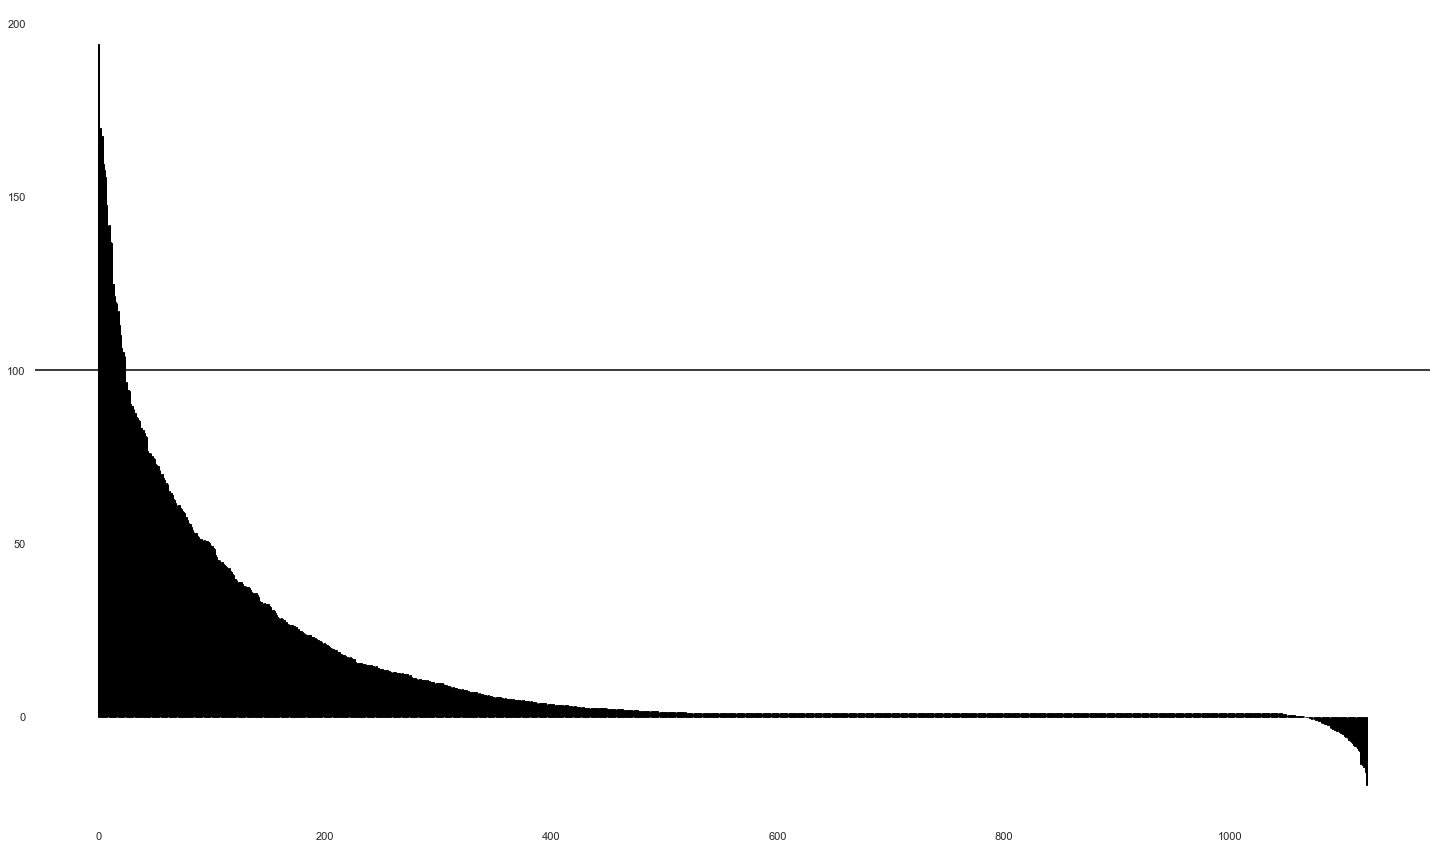

In [114]:
x = list(df_with_genotypes.index)
y = list(df_with_genotypes['Predicted_strict_production'])

bar_plot(x, y, path = 'ConStrain_on_google_colab/Data/Plots_for_publication/07_1_LEARN_DataAnalysis/barplot_predicting_remaining_best_combinations')

In [115]:
df_with_genotypes

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Rse,194.227427
1,Smus,CYC1,TPI1,Ara,169.986071
2,Rsep,ENO2,TPI1,Ara,167.691685
3,Smus,ENO2,TPI1,Aan,167.541633
4,Oeu,ENO2,TPI1,Ara,159.657869
...,...,...,...,...,...
1116,Opum,PCK1,TPI1,Clo,-13.766886
1117,Opum,PCK1,TPI1,Rse,-13.964787
1118,Rsep,CYC1,TPI1,Ani,-14.636814
1119,Rsep,PCK1,TPI1,Ara,-15.92987


Lets save the dataframes into csv files

In [116]:
# getting a unique name
from datetime import datetime
now = datetime.now() # current date and time
time = now.strftime("%Y_%m_%d_%H:%M_")

name = 'top_ML_predicted_after_first_DBTL_merged_analytics'
path = 'ConStrain_on_google_colab/Data/AutoML/'

df_with_genotypes.to_csv(path+time+name+'.csv', index=False)

## 7. Top 20 predicted producers of the unseen library

Lets look at the file generated first from one of the first models. 

In [117]:
df_with_genotypes = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/top_ML_predicted_after_first_DBTL_merged_analytics.csv')

In [118]:
df_with_genotypes

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Cro,226.138557
1,Smus,ENO2,TPI1,Clo,210.261962
2,Smus,ENO2,TPI1,Cac,205.359575
3,Smus,ENO2,TPI1,Aan,204.539731
4,Rsep,ENO2,TPI1,Cro,193.218189
...,...,...,...,...,...
1116,Rsep,PCK1,CCW12,Rse,-2.813507
1117,Ccal,PCK1,TPI1,Ara,-3.103402
1118,Cro,PCK1,TPI1,Ani,-3.587722
1119,Vmin,PCK1,TPI1,Ani,-3.955426


Adding unique names 

In [119]:
df_with_genotypes['names'] = df_with_genotypes['G8H']+'-' +df_with_genotypes['pG8H']+ '_'+ df_with_genotypes['pCPR']+'_'+df_with_genotypes['CPR']

In [120]:
from constrain.plotting.plotting import horisontal_bar_plot

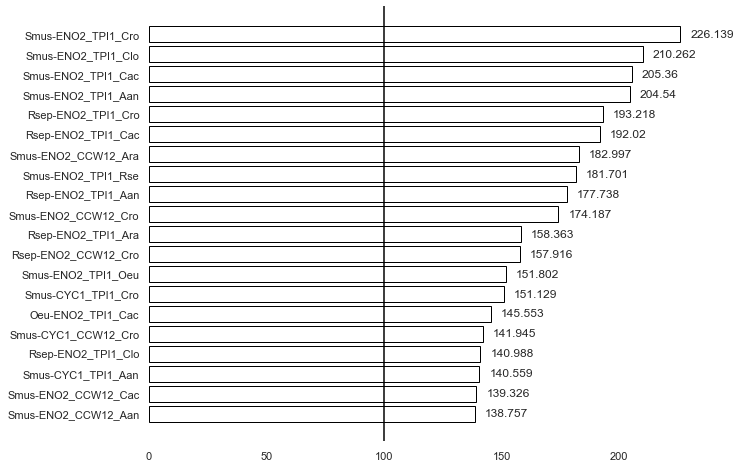

In [121]:
# Plotting top 20 strains
x_axis = list(df_with_genotypes['names'])[:20][::-1]
y_axis = list(df_with_genotypes['Predicted_strict_production'])[:20][::-1]

horisontal_bar_plot(x_axis,y_axis)

### 7.1 How many genotypes are predicted to produce more than the control strain?

In [123]:
over_100_strict_procduction = df_with_genotypes[df_with_genotypes['Predicted_strict_production'] >= 100 ]
print(f"{len(over_100_strict_procduction)} strains out of {len(df_with_genotypes)} showed production of strictosidine over the normalized value")
print(f"Out of the remaing theoretical space these constittue : {(len(over_100_strict_procduction)/len(df_with_genotypes))*100}")

42 strains out of 1121 showed production of strictosidine over the normalized value
Out of the remaing theoretical space these constittue : 3.746654772524532


## 8. Learning curve on partitioned data

In [65]:
from constrain.machine_learning.auto_ml import autoML_on_partitioned_data

Already did this. It takes +20 hours on my laptop.

In [66]:
#feature_cols = ['0', '1', '2', '3']
#training_column = 'Amt_norm'
#
## Training 5 partitions 5 times
#for i in range(0,5): 
#    autoML_on_partitioned_data(feature_cols, training_column,new_input_for_ml,training_time=2, partitions = 5,  path = 'ConStrain_on_google_colab/Data/')

In [67]:
import os

# folder path
dir_path = 'ConStrain_on_google_colab/Data/AutoML/testing_partitioning/'

# list file and directories
res = os.listdir(dir_path)
res

['2022_12_12_13:43_ml_models_running_over_partioned_data.csv',
 '2022_12_12_03:42_ml_models_running_over_partioned_data.csv',
 '2022_12_12_17:46_ml_models_running_over_partioned_data.csv',
 '2022_12_12_08:42_ml_models_running_over_partioned_data.csv',
 '2022_12_12_22:43_ml_models_running_over_partioned_data.csv',
 '.ipynb_checkpoints']

In [68]:
lst_of_pd_dataframes = []
for ml_partitioned in res:
    if ml_partitioned.endswith('.csv'):
        lst_of_pd_dataframes.append(pd.read_csv(dir_path+ml_partitioned))

Lets retrieve the data 

In [69]:
dfs = [df.set_index('Unnamed: 0') for df in lst_of_pd_dataframes]
concated = pd.concat(dfs, axis=1)
concated

,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
34,8.733436,25.789782,14.931739,XGBoost_grid_1_AutoML_21_20221211_84245_model_42,9.083024,25.401035,13.331240,XGBoost_grid_1_AutoML_11_20221210_224400_model_413,6.675266,24.910587,12.280169,XGBoost_grid_1_AutoML_1_20221210_125031_model_2422,8.733436,25.789782,14.931739,XGBoost_grid_1_AutoML_16_20221211_34239_model_42,9.083024,25.401035,13.331240,XGBoost_grid_1_AutoML_6_20221210_174626_model_413
68,11.985398,26.259956,10.220875,GBM_grid_1_AutoML_22_20221211_94239_model_86,6.301959,24.978912,7.250958,DeepLearning_grid_1_AutoML_12_20221210_234350_model_66,6.967622,22.461763,8.040198,DeepLearning_grid_2_AutoML_2_20221210_135023_model_46,16.109195,24.619497,9.166811,DeepLearning_grid_1_AutoML_17_20221211_44239_model_55,8.278626,24.900389,15.947713,StackedEnsemble_BestOfFamily_6_AutoML_7_20221210_184616
102,9.272970,16.755064,6.498705,XGBoost_grid_1_AutoML_23_20221211_104235_model_77,6.116205,15.227977,9.801578,StackedEnsemble_BestOfFamily_6_AutoML_13_20221211_04250,10.127439,15.153594,5.785358,XGBoost_lr_search_selection_AutoML_3_20221210_144651_select_grid_m...,8.081040,15.894132,6.212905,XGBoost_grid_1_AutoML_18_20221211_54224_model_165,8.784116,15.486078,5.834875,XGBoost_lr_search_selection_AutoML_8_20221210_194436_select_grid_m...
136,7.679380,13.364266,7.917948,StackedEnsemble_BestOfFamily_5_AutoML_24_20221211_114254,6.120382,10.771065,4.090960,DeepLearning_grid_1_AutoML_14_20221211_14226_model_17,5.948082,11.768704,4.558317,XGBoost_lr_search_selection_AutoML_4_20221210_154635_select_grid_m...,5.988667,11.953938,4.528992,XGBoost_grid_1_AutoML_19_20221211_64227_model_165,7.402879,12.462551,7.096219,StackedEnsemble_BestOfFamily_5_AutoML_9_20221210_204413
169,6.015689,11.216352,3.722828,XGBoost_grid_1_AutoML_25_20221211_124300_model_77,5.621644,9.775297,6.148426,StackedEnsemble_BestOfFamily_5_AutoML_15_20221211_24225,6.163272,10.099213,5.935413,StackedEnsemble_BestOfFamily_5_AutoML_5_20221210_164637,4.915927,10.203562,3.874008,XGBoost_grid_1_AutoML_20_20221211_74241_model_165,4.581688,9.884541,3.341709,DeepLearning_grid_1_AutoML_10_20221210_214412_model_17


In [70]:
# test results
test_results = concated[['0']]
test_results['mean'] = test_results.mean(axis=1)
test_results['std'] = test_results.std(axis=1)
test_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_3144/934127194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['mean'] = test_results.mean(axis=1)
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_3144/934127194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['std'] = test_results.std(axis=1)


,0,0,0,0,0,mean,std
Unnamed: 0,,,,,,,
34,8.733436,9.083024,6.675266,8.733436,9.083024,8.461637,0.906765
68,11.985398,6.301959,6.967622,16.109195,8.278626,9.928560,3.662581
102,9.272970,6.116205,10.127439,8.081040,8.784116,8.476354,1.355136
136,7.679380,6.120382,5.948082,5.988667,7.402879,6.627878,0.752934
169,6.015689,5.621644,6.163272,4.915927,4.581688,5.459644,0.615948


In [71]:
# Cross-validated mean MAE
cross_validated_results = concated[['CV_mean_MAE']]
cross_validated_results['mean'] = cross_validated_results.mean(axis=1)
cross_validated_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_3144/994047639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results['mean'] = cross_validated_results.mean(axis=1)


,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,mean
Unnamed: 0,,,,,,
34,25.789782,25.401035,24.910587,25.789782,25.401035,25.458444
68,26.259956,24.978912,22.461763,24.619497,24.900389,24.644103
102,16.755064,15.227977,15.153594,15.894132,15.486078,15.703369
136,13.364266,10.771065,11.768704,11.953938,12.462551,12.064105
169,11.216352,9.775297,10.099213,10.203562,9.884541,10.235793


In [72]:
# Cross-validated mean SD
cross_validated_results_sd = concated[['CV_SD_MAE']]
cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)
cross_validated_results_sd

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_3144/3504483626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)


,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,mean
Unnamed: 0,,,,,,
34,14.931739,13.331240,12.280169,14.931739,13.331240,13.761226
68,10.220875,7.250958,8.040198,9.166811,15.947713,10.125311
102,6.498705,9.801578,5.785358,6.212905,5.834875,6.826684
136,7.917948,4.090960,4.558317,4.528992,7.096219,5.638487
169,3.722828,6.148426,5.935413,3.874008,3.341709,4.604477


In [73]:
from constrain.plotting.plotting import plot_ml_learning_curve

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


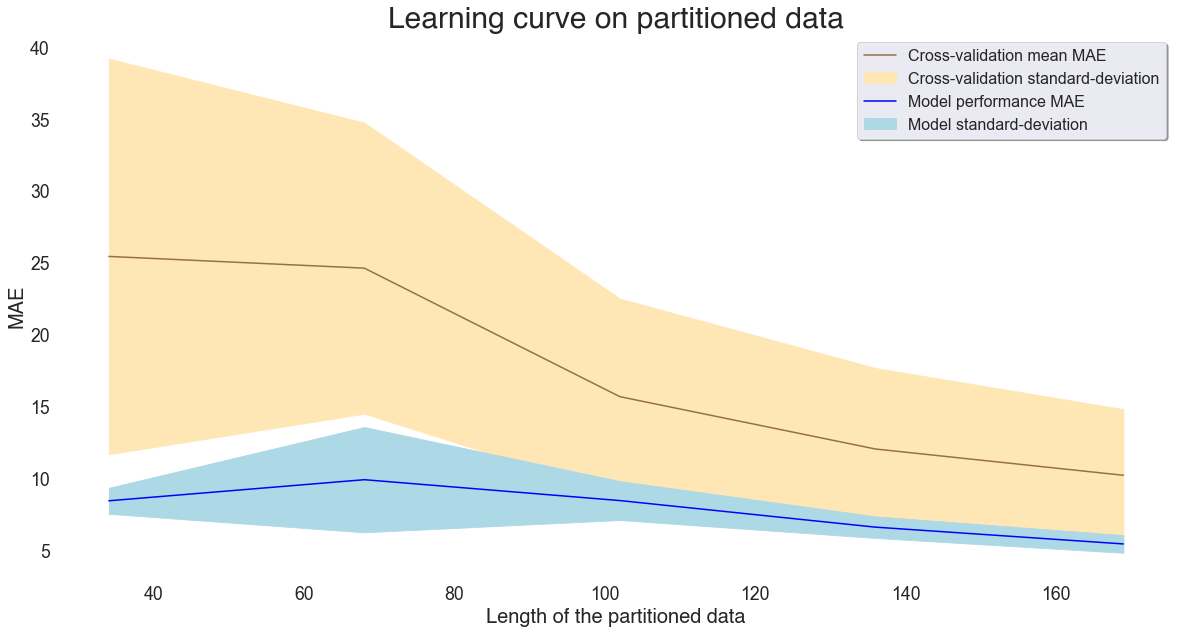

In [74]:
# CV
x = list(cross_validated_results.index)
y = list(cross_validated_results['mean'])
sd =  list(cross_validated_results_sd['mean'])

# model_performance
y1 = list(test_results['mean'])
sd1 = np.array(list(test_results['std']))


plot = plot_ml_learning_curve(x, y1, y,sd1,  sd, save_pdf = True , path = 'ConStrain_on_google_colab/Data/Plots_for_publication/07_1_LEARN_DataAnalysis/Learning_curve_on_partitioned_data_DBTL1')